In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
import data_processing
path = "data/bigdf.pkl"
df = data_processing.load_options(path)
for data in  data_processing.train_test_split(df=df, window=1):
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

loading data data/bigdf.pkl ....


C:\Users\luo\PycharmProjects\hyperband-option\data_processing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['moneyness'] = df['mid']/df['exeprice']


In [3]:
x_train.head()
x_train['moneyness'].describe()

count    12877.000000
mean         0.039195
std          0.043387
min          0.000385
25%          0.006326
50%          0.023894
75%          0.057595
max          0.202167
Name: moneyness, dtype: float64

In [4]:
m_values = x_train['moneyness'].reshape((-1,1)).astype(np.float32)
t_values = x_train['years_to_exe'].reshape((-1,1)).astype(np.float32)
s_values = x_train['etf_mid'].reshape((-1,1)).astype(np.float32)
c_values = y_train.reshape((-1,1)).astype(np.float32)

C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [5]:
m_test_values = x_test['moneyness'].reshape((-1,1)).astype(np.float32)
t_test_values = x_test['years_to_exe'].reshape((-1,1)).astype(np.float32)
s_test_values = x_test['etf_mid'].reshape((-1,1)).astype(np.float32)
c_test_values = y_test.reshape((-1,1)).astype(np.float32)

C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Users\luo\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [6]:
num_features = 3
num_neurons = 5 #J
num_gates = 9 #I could be changed
num_gate_neurons = 5 #K
r = 0.06
batch_size = 16
num_epochs = 14000
# np.exp(r*t)*st*c_predict to be true value

In [7]:
with tf.name_scope("placehoders"):
    m = tf.placeholder(tf.float32, [None,1], name='m')
    t = tf.placeholder(tf.float32, [None,1], name='t')
    c = tf.placeholder(tf.float32, [None,1], name='c')
    st = tf.placeholder(tf.float32, [None,1], name='st')

In [8]:
w =  tf.Variable(tf.truncated_normal([num_neurons,1]), name="weights")
wm = tf.Variable(tf.truncated_normal([1, num_neurons]), name="weights_m")
bm = tf.Variable(tf.truncated_normal([num_neurons]), name="bias_m")
wt = tf.Variable(tf.truncated_normal([1, num_neurons]), name="weights_t")
bt = tf.Variable(tf.truncated_normal([num_neurons]), name="bias_t")
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

In [9]:
sigma_m = tf.nn.softplus( tf.scalar_mul(-1.0, tf.matmul(m, tf.exp(wm))) + bm, name="sigma_m")
sigma_t = tf.nn.sigmoid(tf.matmul(t, tf.exp(wt)) + bt, name="sigma_t")

In [10]:
c_predict = tf.matmul(sigma_m*sigma_t,tf.exp(w), name="c_predict")
c_predict_real = tf.exp(-1.0*r*t)*st*c_predict
#loss = tf.losses.mean_squared_error(c, c_predict*np.exp(-1.0*r*t)*st)
loss = tf.losses.mean_squared_error(c_predict_real, c)
optimizer = tf.train.AdamOptimizer(0.5).minimize(loss, name="optimizer",global_step=global_step)

In [11]:
with tf.name_scope("summaries"):
    tf.summary.scalar("loss", loss)
    tf.summary.histogram("histogram_loss", loss)
    summary_op = tf.summary.merge_all()

In [12]:
import os
init = tf.global_variables_initializer()
with tf.Session() as sess:
    writer = tf.summary.FileWriter("log/tf_2", sess.graph)
    saver = tf.train.Saver(max_to_keep=30)
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints_2/checkpoint'))
    # if that checkpoint exists, restore from checkpoint
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(init)
    start = global_step.eval()
    for step in range(start, num_epochs):
        _, loss_value, summary = sess.run([optimizer, loss, summary_op], {m:m_values, t:t_values, st:s_values, c:c_values})
        writer.add_summary(summary, global_step=step)
        if(step % 1000 == 0):
            print('Loss at step {}: {}'.format(step, loss_value))
            loss_test = sess.run([loss], {m:m_test_values, t:t_test_values, st:s_test_values, c:c_test_values})
            print('Loss at test {}: {}'.format(step, loss_test))    
            saver.save(sess, 'checkpoints_2/model', step)
            print('Saved model at step {} with test loss: {}'.format(step, loss_test))
    c_predict_values = sess.run([c_predict_real], {m:m_test_values, t:t_test_values, st:s_test_values, c:c_test_values})
    writer.close()

Loss at step 0: 39.91233825683594
Loss at test 0: [3.4571049]


Saved model at step 0 with test loss: [3.4571049]


Loss at step 1000: 0.013526976108551025
Loss at test 1000: [0.011209366]


Saved model at step 1000 with test loss: [0.011209366]


Loss at step 2000: 0.013513492420315742
Loss at test 2000: [0.011196692]


Saved model at step 2000 with test loss: [0.011196692]


Loss at step 3000: 0.01347276195883751
Loss at test 3000: [0.011159444]


Saved model at step 3000 with test loss: [0.011159444]


Loss at step 4000: 0.006798136979341507
Loss at test 4000: [0.0054934686]


Saved model at step 4000 with test loss: [0.0054934686]


Loss at step 5000: 0.005500543862581253
Loss at test 5000: [0.0045762984]


Saved model at step 5000 with test loss: [0.0045762984]


Loss at step 6000: 0.005493187811225653
Loss at test 6000: [0.0045700199]


Saved model at step 6000 with test loss: [0.0045700199]


Loss at step 7000: 0.005488501861691475
Loss at test 7000: [0.0045656757]


Saved model at step 7000 with test loss: [0.0045656757]


Loss at step 8000: 0.005485916044563055
Loss at test 8000: [0.0045633223]


Saved model at step 8000 with test loss: [0.0045633223]


Loss at step 9000: 0.0054842038080096245
Loss at test 9000: [0.0045478805]


Saved model at step 9000 with test loss: [0.0045478805]


Loss at step 10000: 0.0054163155145943165
Loss at test 10000: [0.0045337435]


Saved model at step 10000 with test loss: [0.0045337435]


Loss at step 11000: 0.0054160188883543015
Loss at test 11000: [0.0045348825]


Saved model at step 11000 with test loss: [0.0045348825]


Loss at step 12000: 0.005415855906903744
Loss at test 12000: [0.0045342017]


Saved model at step 12000 with test loss: [0.0045342017]


Loss at step 13000: 0.00541582889854908
Loss at test 13000: [0.0045341561]


Saved model at step 13000 with test loss: [0.0045341561]


In [15]:
c_predict_values

[array([[ 0.10666332],
        [ 0.10691991],
        [ 0.10679045],
        ..., 
        [ 0.12004589],
        [ 0.11993337],
        [ 0.11993339]], dtype=float32)]

In [16]:
c_predict_values[0].shape
c_test_values.shape

(13885, 1)

In [18]:
c_test_values.shape
result = pd.DataFrame(c_test_values, columns=["c_values"])
result["c_predict_values"] = c_predict_values[0]

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

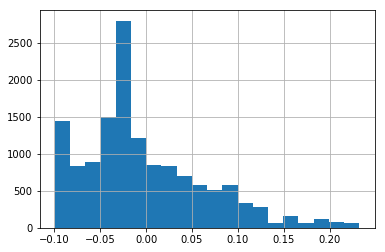

In [20]:
result.describe()
(result["c_values"] - result["c_predict_values"]).hist(bins=20)
plt.show()

In [12]:
mt_combine = tf.concat([m,t], axis=1)
wg = tf.Variable(tf.truncated_normal([2,num_gate_neurons]), name="weights_gate")
bg = tf.Variable(tf.truncated_normal([num_gate_neurons]), name = "bias_gate")
hidden= tf.nn.sigmoid(tf.matmul(mt_combine, wg) +bg)
wgo = tf.Variable(tf.truncated_normal([num_gate_neurons, num_gates]), name="wg_output")
bgo = tf.Variable(tf.truncated_normal([num_gates]), name = "bg_output")
logits = tf.matmul(hidden, wgo) + bgo
gates = tf.nn.softmax(logits, name="gates")